# Dark Matter

Indirect dark matter detection works under the assumption that dark matter is particle-like and decays or annihilates into standard model particles. These standard model particles can then further decay or through other processes produce by-products such as photons.

`GammaBayes` is interested in relating the flux and properties of these gamma-rays if they exist back to important dark matter parameters such as it's mass and thermally averaged velocity-weighted annihilation cross-section.

This is currently handled with two 'combination' classes that either take a physics model-dependent or model-independent approach to the search for dark matter. We will first discuss the model dependent approach and later on how this differs to the model-independent approach.

## `CombineDMComps`

As in the name `CombineDMComps` combines a spectral dark matter distribution and a spatial distribution to construct a `TwoCompFluxPrior` class as discussed in the priors and simulations tutorial.

You must provide it with a `DM_ContinuousEmission_Spectrum` class and a `DM_Profile` class each of which are base classes for specific models (spectral and spatial respectively).

### `DM_ContinuousEmission_Spectrum`

`DM_ContinuousEmission_Spectrum` is used as a base for any single-particle dark matter model that you wish to implement. That can mean implementing a full blown physics motivated model like the Z2 real scalar singlet model or as simple as a single $W^+W^-$ channel model.

`DM_ContinuousEmission_Spectrum` takes in three main arguments:
    - `annihilation_fractions` a mesh of the annihilation ratios that are outputs of a given dark matter model,
    - `parameter_interpolation_values` the parameter axes that created the above mesh and,
    - `ratios` a bool to enforce the `annihilation_fractions` values to add to 1 or to interpret them as partial annihilation ratios

#### W Channel example

The default behaviour is to instantiate a single channel model for the $W^+W^-$ channel which is just a function of dark matter mass. It works as below.

In [1]:
import numpy as np
from astropy import units as u

from gammabayes.dark_matter.channel_spectra import (
    PPPCReader, 
)

from gammabayes.dark_matter import DM_ContinuousEmission_Spectrum


single_Wchannel_annihilation_ratios   = {}
mass_axis       = np.logspace(-1,2,301)

for channel in PPPCReader.darkSUSY_to_PPPC_converter:
    if channel[0]=="W":
        single_Wchannel_annihilation_ratios[channel] = mass_axis*0+1
    else:
        single_Wchannel_annihilation_ratios[channel] = mass_axis*0


wchannel_spectral_comp = DM_ContinuousEmission_Spectrum(annihilation_fractions=single_Wchannel_annihilation_ratios, 
                 parameter_interpolation_values=[mass_axis], 
                 ratios = True,
                 default_parameter_values = {'mass':1.0,},
                 )

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/dark_matter/spectral_models/core/base_spectral_class.py:121: RuntimeWarning: divide by zero encountered in log
  self.log_normalisations = np.logaddexp(self.log_normalisations, np.log(annihilation_fractions[channel]))
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/dark_matter/spectral_models/core/base_spectral_class.py:126: RuntimeWarning: divide by zero encountered in log
  new_annihilation_fractions = np.exp(np.log(annihilation_fractions[channel])-self.log_normalisations)


You can extract the values of this function using the `logfunc` method.

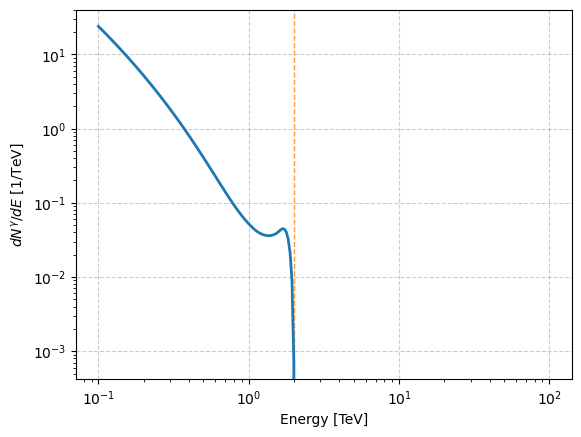

In [3]:
test_energies = np.logspace(-1, 2, 241)*u.TeV
test_mass = 2 # TeV
log_spectra = wchannel_spectral_comp.logfunc(energy=test_energies.flatten(), 
                                             mass=test_mass)


from matplotlib import pyplot as plt


plt.figure()
plt.grid(c='grey', ls='--', alpha=0.4,which='major')
plt.axvline(test_mass, c='tab:orange', ls='--', alpha=0.8, lw=1)
plt.plot(test_energies.value, np.exp(log_spectra.squeeze()), lw=2)
plt.ylabel(r'$dN^\gamma/dE$ [1/TeV]')
plt.xlabel("Energy [TeV]")
plt.loglog()
plt.show()

The units should also be handled so you can mess around with that.

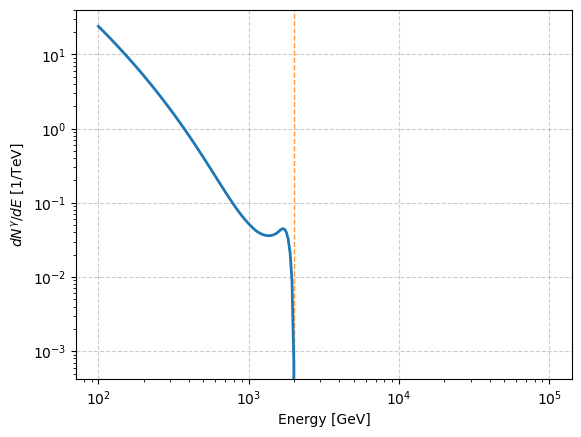

In [4]:
test_energies = np.logspace(2, 5, 241)*u.GeV
test_mass = 2 # TeV
log_spectra = wchannel_spectral_comp.mesh_efficient_logfunc(energy=test_energies, mass=test_mass)


from matplotlib import pyplot as plt



plt.figure()
plt.grid(c='grey', ls='--', alpha=0.4,which='major')
plt.axvline(test_mass*1000, c='tab:orange', ls='--', alpha=0.8, lw=1)
plt.plot(test_energies.value, np.exp(log_spectra.squeeze()), lw=2)
plt.ylabel(r'$dN^\gamma/dE$ [1/TeV]')
plt.xlabel("Energy [GeV]")
plt.loglog()
plt.show()

However, you'll notice that the y-values didn't change. That is because the output is locked to be 1/TeV unless explicitly stated otherwise. This can be done by changing the `inverse_output_unit` attribute.

In [5]:
wchannel_spectral_comp.inverse_output_unit = u.GeV

Now if we do the same graph again the y-values should have changed (and the appropriate unit).

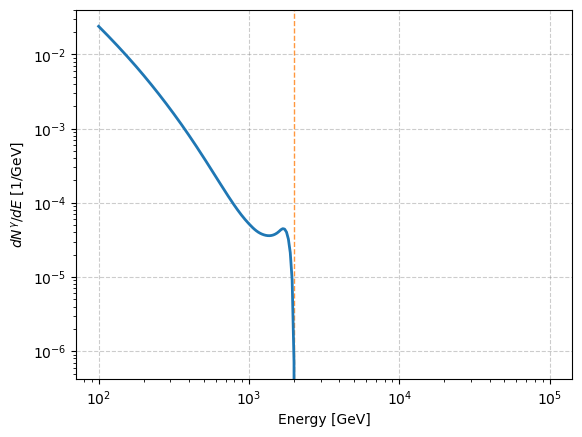

In [6]:
test_energies = np.logspace(2, 5, 241)*u.GeV
test_mass = 2 # TeV
log_spectra = wchannel_spectral_comp.logfunc(energy=test_energies, mass=test_mass)


from matplotlib import pyplot as plt



plt.figure()
plt.grid(c='grey', ls='--', alpha=0.4,which='major')
plt.axvline(test_mass*1000, c='tab:orange', ls='--', alpha=0.8, lw=1)
plt.plot(test_energies.value, np.exp(log_spectra.squeeze()), lw=2)
plt.ylabel(r'$dN^\gamma/dE$ [1/GeV]')
plt.xlabel("Energy [GeV]")
plt.loglog()
plt.show()

If that worked, hoorray! If it didn't... raise an issue in the GitHub repo. 


Another small thing is that for this method I presume that the inputs are either the same size/shape or I presume that the extra parameters are single-valued and I add them to a zero matrix of the same size as the energy input. If you want to put in multiple axes of parameters and get a mesh out then you can use the `mesh_efficient_logfunc` method. e.g.

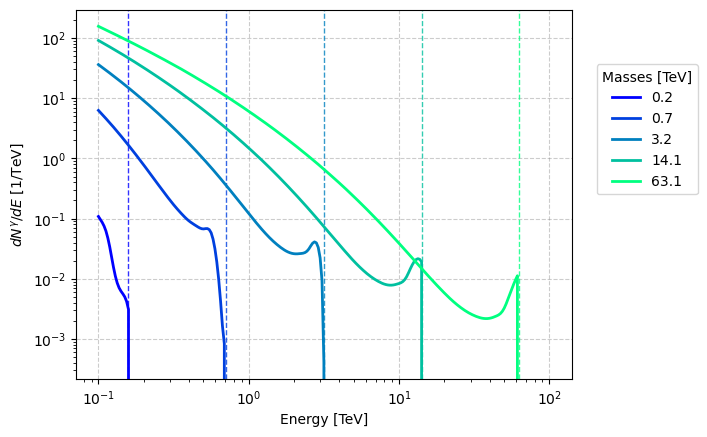

In [8]:
test_energies = np.logspace(-1, 2, 241)*u.TeV
test_masses = np.logspace(-0.8, 1.8, 5) # TeV

wchannel_spectral_comp.inverse_output_unit = u.TeV
log_spectra = wchannel_spectral_comp.mesh_efficient_logfunc(energy=test_energies, mass=test_masses)


from matplotlib import pyplot as plt
from matplotlib.pyplot import get_cmap
from matplotlib.colors import Normalize

norm = Normalize(vmin=0, vmax=len(test_masses)-1)

cmap = get_cmap("winter")
plt.figure()
plt.grid(c='grey', ls='--', alpha=0.4,which='major')
for mass_idx, mass in enumerate(test_masses):

    color = cmap(norm(mass_idx)) 
    plt.axvline(mass, ls='--', alpha=0.8, lw=1, c=color)

    plt.plot(test_energies.value, np.exp(log_spectra[:, mass_idx].squeeze()), lw=2, c=color, label=f"{mass:.1f}")
plt.legend(title="Masses [TeV]", loc=[1.05, 0.5])
plt.ylabel(r'$dN^\gamma/dE$ [1/TeV]')
plt.xlabel("Energy [TeV]")
plt.loglog()
plt.show()

#### `Z2_ScalarSinglet` + custom example

Let's say that you have your own single particle dark matter model that you wish to use. As previously stated you need to provide parameter axes and a matrix where these parameters relate to the annihilation ratios/branching fraction/partial annihilation or decay cross sections of the model. 

We will copy how this is done for the built-in Z2 Scalar Singlet dark matter model.

In `GammaBayes` there contains a table of mass, Higgs coupling and the subsequent annihilation ratios for many standard model particle channels.

In [9]:
import numpy as np, copy
from os import path
from gammabayes.dark_matter.spectral_models.core import CSVDictionary
from gammabayes.dark_matter.spectral_models.Z2_ScalarSinglet.SS_DM_Spectral_Class import ScalarSinglet_Folder_Path



annihilation_ratio_data_dict = CSVDictionary(ScalarSinglet_Folder_Path+f'/annihilation_ratio_data/annihilation_ratios__darkSUSY.csv', delimiter=' ')
annihilation_ratio_data_dict.dict_object

{'mS [GeV]': array([1.00000000e+01, 1.04693645e+01, 1.09607592e+01, ...,
        9.55167817e+05, 1.00000000e+06, 1.04693645e+06], dtype=float128),
 'lahS': array([1.00000005e-03, 1.00000005e-03, 1.00000005e-03, ...,
        1.00000000e+01, 1.00000000e+01, 1.00000000e+01]),
 'nuenue': array([0., 0., 0., ..., 0., 0., 0.]),
 'e+e-': array([1.03788572e-39, 1.04312237e-39, 1.04890974e-39, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'numunumu': array([0., 0., 0., ..., 0., 0., 0.]),
 'mu+mu-': array([4.43652403e-35, 4.39327927e-35, 4.41562256e-35, ...,
        7.84727140e-44, 6.44597294e-44, 5.32493416e-44]),
 'nutaunutau': array([0., 0., 0., ..., 0., 0., 0.]),
 'tau+tau-': array([1.19613419e-32, 1.21407701e-32, 1.22493785e-32, ...,
        2.20256093e-41, 1.83331878e-41, 1.52601403e-41]),
 'uu': array([1.07317692e-37, 1.07859288e-37, 1.08457642e-37, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'dd': array([4.29270588e-37, 4.31437018e-37, 4.33830435e-37,

The mass and lahS (Higgs coupling) are inputs and the other values are the outputs. We just need to extract the inputs...

In [10]:

# Extracting the annihilation ratios for the Scalar Singlet model
mass_axis, lahS_axis = np.unique(annihilation_ratio_data_dict['mS [GeV]'])/1000, np.unique(annihilation_ratio_data_dict['lahS'])

SS_ratios_dict = copy.deepcopy(annihilation_ratio_data_dict)

del SS_ratios_dict['mS [GeV]']
del SS_ratios_dict['lahS']

parameter_interpolation_values = [mass_axis, lahS_axis]
parameter_axes_shapes = (lahS_axis.size, mass_axis.size)


And reshape the outputs so that we can interpolate them.

In [11]:

for channel in SS_ratios_dict.keys():
    SS_ratios_dict[channel] = SS_ratios_dict[channel].reshape(parameter_axes_shapes).T



And then we pass the annihilation ratios or branching fractions into annihilation_fractions

and the two parameter axis in a list to parameter_interpolation_values

and the defaults for the parameters. The defaults are required for unit matching and value replacement when un-specified.

In [12]:
manual_z2_spectral_comp = DM_ContinuousEmission_Spectrum(annihilation_fractions = SS_ratios_dict, 
                    parameter_interpolation_values = parameter_interpolation_values,
                    default_parameter_values={'mass':1.0, 'lahS':0.1},)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/dark_matter/spectral_models/core/base_spectral_class.py:121: RuntimeWarning: divide by zero encountered in log
  self.log_normalisations = np.logaddexp(self.log_normalisations, np.log(annihilation_fractions[channel]))
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/dark_matter/spectral_models/core/base_spectral_class.py:126: RuntimeWarning: divide by zero encountered in log
  new_annihilation_fractions = np.exp(np.log(annihilation_fractions[channel])-self.log_normalisations)


Then we use the class in the same way as before.

In [13]:
test_energies = np.logspace(-1, 2, 241)*u.TeV
test_masses = np.logspace(-0.8, 1.8, 5)


manual_z2_spectral_comp.inverse_output_unit = u.TeV
log_spectra = manual_z2_spectral_comp.mesh_efficient_logfunc(energy=test_energies, mass=test_masses, lahS=0.2)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/dark_matter/spectral_models/core/base_spectral_class.py:223: RuntimeWarning: divide by zero encountered in log
  log_channel_comp = np.log(channel_comp) - np.log((energy*u.TeV).to(self.inverse_output_unit).value) - np.log(np.log(10))


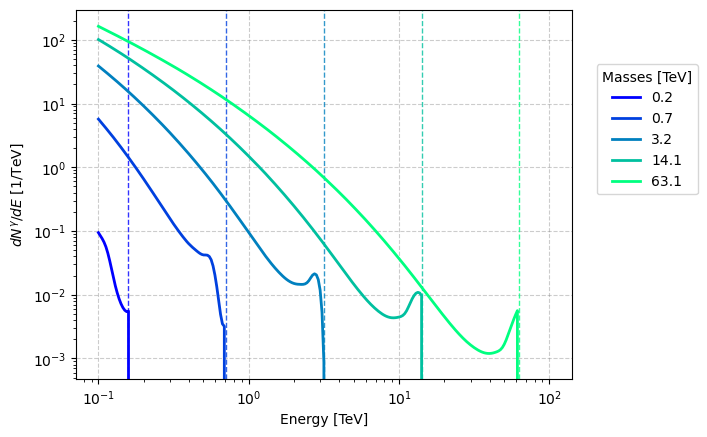

In [15]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import get_cmap
from matplotlib.colors import Normalize

norm = Normalize(vmin=0, vmax=len(test_masses)-1)

cmap = get_cmap("winter")
plt.figure()
plt.grid(c='grey', ls='--', alpha=0.4,which='major')
for mass_idx, mass in enumerate(test_masses):

    color = cmap(norm(mass_idx)) 
    plt.axvline(mass, ls='--', alpha=0.8, lw=1, c=color)

    plt.plot(test_energies.value, np.exp(log_spectra[:, mass_idx].squeeze()), lw=2, c=color, label=f"{mass:.1f}")
plt.legend(title="Masses [TeV]", loc=[1.05, 0.5])
plt.ylabel(r'$dN^\gamma/dE$ [1/TeV]')
plt.xlabel("Energy [TeV]")
plt.loglog()
plt.show()

This looks fairly similar to the single W channel spectrum, that is because the W channel makes the largest contributions above ~100 GeV for the Z2 Scalar Singlet dark matter model.

And again, `GammaBayes` has the Z2 Scalar Singlet dark matter model built-in and you can instantiate in the following way.

In [16]:
from gammabayes.dark_matter.spectral_models import Z2_ScalarSinglet


auto_z2_scalar_singlet_comp = Z2_ScalarSinglet()


test_energies = np.logspace(-1, 2, 241)*u.TeV
test_masses = np.logspace(-0.8, 1.8, 5) # TeV


auto_z2_scalar_singlet_comp.inverse_output_unit = u.TeV
log_spectra = auto_z2_scalar_singlet_comp.mesh_efficient_logfunc(energy=test_energies, mass=test_masses, lahS=0.2)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/dark_matter/spectral_models/core/base_spectral_class.py:121: RuntimeWarning: divide by zero encountered in log
  self.log_normalisations = np.logaddexp(self.log_normalisations, np.log(annihilation_fractions[channel]))
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/dark_matter/spectral_models/core/base_spectral_class.py:126: RuntimeWarning: divide by zero encountered in log
  new_annihilation_fractions = np.exp(np.log(annihilation_fractions[channel])-self.log_normalisations)
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/dark_matter/spectral_models/core/base_spectral_class.py:223: RuntimeWarning: divide by zero encountered in log
  log_channel_comp = np.log(channel_comp) - np.log((energy*u.TeV).to(self.inverse_output_unit).value) - np.log(np.log(10))


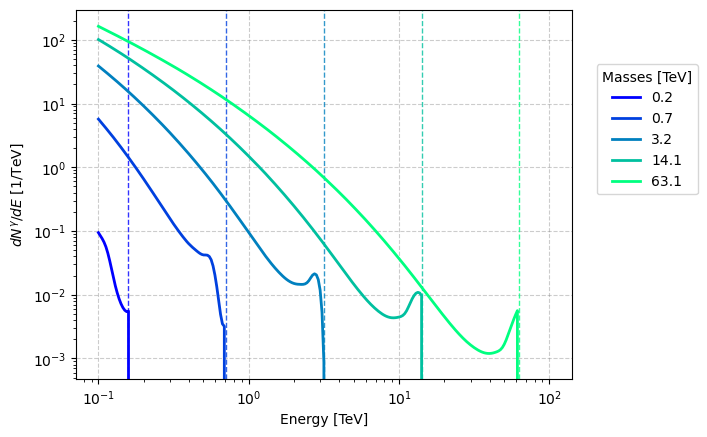

In [17]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import get_cmap
from matplotlib.colors import Normalize

norm = Normalize(vmin=0, vmax=len(test_masses)-1)

cmap = get_cmap("winter")
plt.figure()
plt.grid(c='grey', ls='--', alpha=0.4,which='major')
for mass_idx, mass in enumerate(test_masses):

    color = cmap(norm(mass_idx)) 
    plt.axvline(mass, ls='--', alpha=0.8, lw=1, c=color)

    plt.plot(test_energies.value, np.exp(log_spectra[:, mass_idx].squeeze()), lw=2, c=color, label=f"{mass:.1f}")
plt.legend(title="Masses [TeV]", loc=[1.05, 0.5])
plt.ylabel(r'$dN^\gamma/dE$ [1/TeV]')
plt.xlabel("Energy [TeV]")
plt.loglog()
plt.show()

### `DM_Profile`

The other component to dark matter models are the spatial distributions. In `GammaBayes` we don't offer much in the way of custom distributions but we do offer some standard distributions such as the `Einasto_Profile`, `NFW_Profile` and `Burkert_Profile`.

You can access them as below.

In [18]:
from gammabayes.dark_matter.density_profiles import Einasto_Profile, Burkert_Profile


einasto_profile = Einasto_Profile()
burkert_profile = Burkert_Profile()

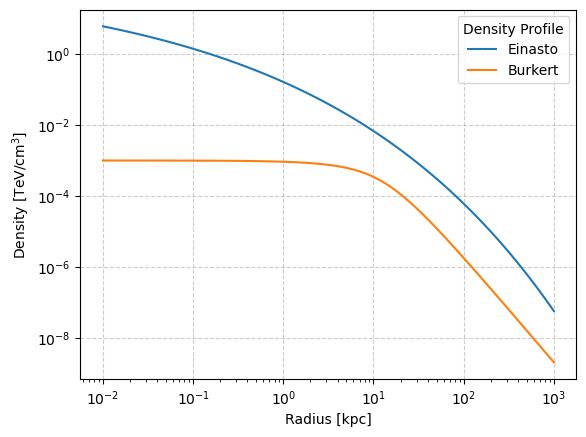

In [19]:
from matplotlib import pyplot as plt
import numpy as np



radii = np.logspace(-2, 3, 121)*u.kpc


plt.figure()
plt.plot(radii.value, np.exp(einasto_profile.log_density(radii)), label='Einasto')
plt.plot(radii.value, np.exp(burkert_profile.log_density(radii)), label='Burkert')
plt.loglog()
plt.xlabel("Radius [kpc]")
plt.ylabel(r"Density [TeV/cm$^3$]")
plt.legend(title="Density Profile")
plt.grid(which='major', c='grey', ls='--', alpha=0.4)
plt.show()

And unlike with the spectral profiles the output unit of this function is currently fixed at $\text{TeV}/\text{cm}^3$. This will be fixed very soon (current date 02/09/24)

The main quantity we want out of the profile is the differential J or D factor which is the output when directly calling the class.

In [20]:
from matplotlib import pyplot as plt
import numpy as np

longitude_values = np.linspace(-3, 3, 61)*u.deg
latitude_values = np.linspace(-2, 2, 40)*u.deg

lon_mesh, lat_mesh = np.meshgrid(longitude_values, latitude_values, indexing='ij')

diffJ_values = np.exp(einasto_profile(lon_mesh.flatten(), lat_mesh.flatten()).reshape(lon_mesh.shape))

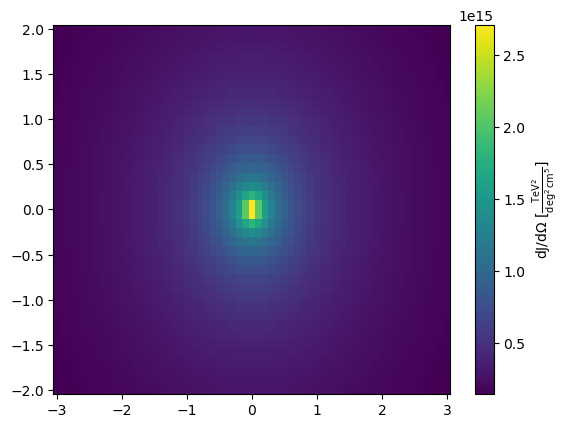

In [21]:

plt.figure()
plt.pcolormesh(longitude_values.value, latitude_values.value, diffJ_values.T)
plt.colorbar(label=r"dJ/d$\Omega$ ["+u.Unit(einasto_profile.diffJ_units).to_string('latex')+r"]")

plt.show()

You _can_ change the output value on this level either through the `diffJ_units` or `diffD_units` attributes/class parameters.

In [22]:
from gammabayes.dark_matter.density_profiles import Einasto_Profile, Burkert_Profile


diffJ_unit_einasto_profile = Einasto_Profile(diffJ_units='GeV2 cm-5 deg-2')


In [23]:
from matplotlib import pyplot as plt
import numpy as np

longitude_values = np.linspace(-3, 3, 61)*u.deg
latitude_values = np.linspace(-2, 2, 40)*u.deg

lon_mesh, lat_mesh = np.meshgrid(longitude_values, latitude_values, indexing='ij')

diffJ_values = np.exp(diffJ_unit_einasto_profile(lon_mesh.flatten(), lat_mesh.flatten()).reshape(lon_mesh.shape))

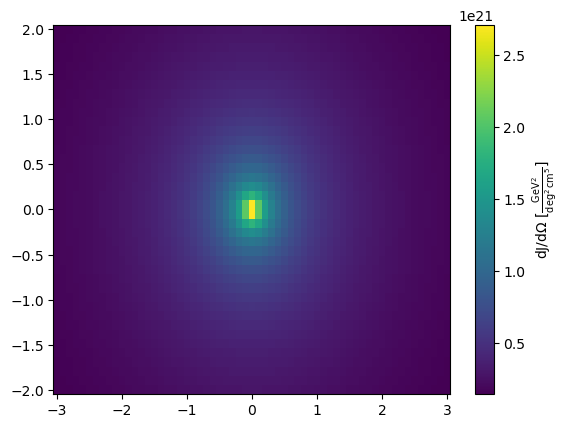

In [24]:
plt.figure()
plt.pcolormesh(longitude_values.value, latitude_values.value, diffJ_values.T)
plt.colorbar(label=r"dJ/d$\Omega$ ["+u.Unit(diffJ_unit_einasto_profile.diffJ_units).to_string('latex')+r"]")

plt.show()

The final consideration here is that we cannot currently support probing the exact centre of the dark matter profiles due to a small thing involving how the integration over the line of sight is done. We hope to also fix this soon.

### Using `CombineDMComps`

Now that we know how to instantiate the individual components, then all we need to do is put them in the `CombineDMComps` class which inherits from the `TwoCompFluxPrior` class thus takes the same initial arguments besides the function which is handled by `CombineDMComps`.

In [25]:
from gammabayes.dark_matter import CombineDMComps
from gammabayes import GammaBinning
from gammabayes.likelihoods.irfs import IRF_LogLikelihood

true_binning_geometry = GammaBinning(energy_axis=np.logspace(-1,2,181)*u.TeV, lon_axis=np.linspace(-4, 4, 81)*u.deg, lat_axis=np.linspace(-3, 3, 60)*u.deg)
recon_binning_geometry = GammaBinning(energy_axis=np.logspace(-1,2,91)*u.TeV, lon_axis=np.linspace(-4, 4, 41)*u.deg, lat_axis=np.linspace(-3, 3, 30)*u.deg)

pointing = np.array([0.,0.])*u.deg
obs_time = 0.5*u.hr

irf_loglike = IRF_LogLikelihood(
    pointing_dir=pointing,
    observation_time=obs_time,
    binning_geometry=recon_binning_geometry, true_binning_geometry=true_binning_geometry)

dm_prior = CombineDMComps(
    binning_geometry=true_binning_geometry,
    pointing_dir=pointing,
    observation_time = obs_time,
    spectral_class=Z2_ScalarSinglet, spatial_class=Einasto_Profile, irf_loglike=irf_loglike)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/dark_matter/spectral_models/core/base_spectral_class.py:121: RuntimeWarning: divide by zero encountered in log
  self.log_normalisations = np.logaddexp(self.log_normalisations, np.log(annihilation_fractions[channel]))
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/dark_matter/spectral_models/core/base_spectral_class.py:126: RuntimeWarning: divide by zero encountered in log
  new_annihilation_fractions = np.exp(np.log(annihilation_fractions[channel])-self.log_normalisations)


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/dark_matter/spectral_models/core/base_spectral_class.py:223: RuntimeWarning: divide by zero encountered in log
  log_channel_comp = np.log(channel_comp) - np.log((energy*u.TeV).to(self.inverse_output_unit).value) - np.log(np.log(10))


(<Figure size 1600x400 with 5 Axes>,
 array([<Axes: xlabel='Energy [TeV]'>,
        <Axes: xlabel='Longitude [deg]', ylabel='Latitude [deg]'>,
        <Axes: xlabel='Energy [TeV]', ylabel='Longitude [deg]'>],
       dtype=object))

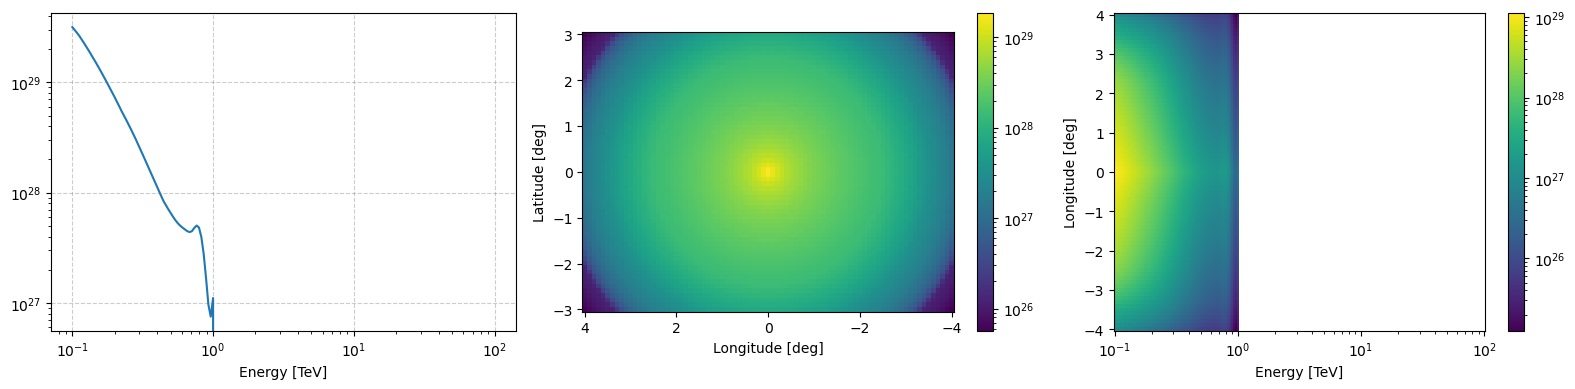

In [26]:
dm_prior.peek(figsize=(16,4), norm='log')

You'll notice that the outputs are extremely high, this is because I'm not exactly getting the flux of dark matter, that would require multiplying the values by $\langle\sigma v\rangle/(m_\chi^2 S_\chi)$ among some other misc constant values. For 99% of the work with this pipeline, the fluxes are normalised anyway so these constants would fall and would just increase the computation time for little reason.

This overall normalisation being so large does mean that when sampling the dark matter distribution we highly highly highly recommend you specify the number of counts rather than leave it to the normalisation.

In [27]:
dark_matter_obs = dm_prior.sample(numsamples=1e4)

array([<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Counts'>,
       <Axes: xlabel='Longitude [$\\mathrm{{}^{\\circ}}$]', ylabel='Latitude [$\\mathrm{{}^{\\circ}}$]'>],
      dtype=object)

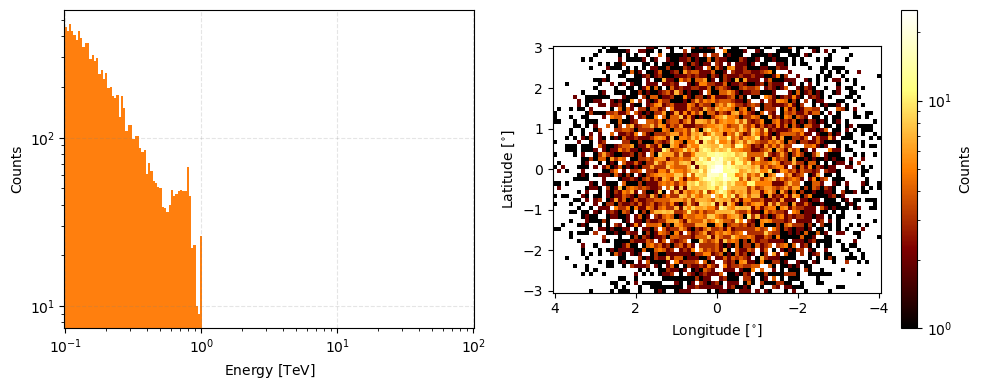

In [28]:
dark_matter_obs.peek(figsize=(10,4), count_scaling='log')

## `CustomDMRatiosModel`

I relatively new feature of `GammaBayes` (Sep 2024) is a dark matter model-independent dark matter model, where you don't presume some underlying physical model but just presume dark matter will annihilate or decay into some combination of the channels mentioned above. 



In [29]:
from gammabayes.dark_matter import CustomDMRatiosModel


custom_ratios_model = CustomDMRatiosModel(
    irf_loglike=irf_loglike,
    axes=true_binning_geometry.axes,
    binning_geometry=true_binning_geometry,
    pointing_dir=pointing,
    observation_time=obs_time,
    channels=['W+W-', 'ZZ', 'HH', 'tt'],
    spatial_class=Einasto_Profile
)

custom_ratios_model.channel_prior_dict

{'W+W-': Discrete log prior class
 --------------------
 Name: W+W- DM Class
 Logfunction type: method
 Input units: None,
 'ZZ': Discrete log prior class
 --------------------
 Name: ZZ DM Class
 Logfunction type: method
 Input units: None,
 'HH': Discrete log prior class
 --------------------
 Name: HH DM Class
 Logfunction type: method
 Input units: None,
 'tt': Discrete log prior class
 --------------------
 Name: tt DM Class
 Logfunction type: method
 Input units: None}

___....Currently undergoing remodelling, sorry for the inconvenience....___

#### Next tutorial

Next we'll go through how `GammaBayes` handles hyper-parameters and before finally getting into how we perform inference on these parameters.